In [1]:
import torch
from torch import nn

import sys
import math
import collections

# sys.path.append(".")
sys.path.append("..")

# import d2lzh_pytorch.torch as d2l
import d2lzh_pytorch.torch_package as d2l
# 导入工具类
from d2lzh_pytorch import myUtils

# 训练数据导入
from d2lzh_pytorch.nlp.load_data.load_nmt_data import load_data_nmt

# 模型导入
from d2lzh_pytorch.nlp.model.Transformer_model import get_transformer

# 训练导入 train_seq2seq
from d2lzh_pytorch.nlp.train.train_seq2seq import train_seq2seq

# 预测
from d2lzh_pytorch.nlp.predict.predict_seq2seq import predict_seq2seq
from d2lzh_pytorch.nlp.predict.predict_seq2seq import bleu

P:\python\anaconda3\envs\d2l_pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 加载训练数据
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)

In [3]:
# 加载模型
net = get_transformer()

In [12]:
from torchsummary import summary

summary(net)

Layer (type:depth-idx)                        Param #
├─TransformerEncoder: 1-1                     --
|    └─Embedding: 2-1                         5,888
|    └─PositionalEncoding: 2-2                --
|    |    └─Dropout: 3-1                      --
|    └─Sequential: 2-3                        --
|    |    └─EncoderBlock: 3-2                 8,416
|    |    └─EncoderBlock: 3-3                 8,416
├─TransformerDecoder: 1-2                     --
|    └─Embedding: 2-4                         6,432
|    └─PositionalEncoding: 2-5                --
|    |    └─Dropout: 3-4                      --
|    └─Sequential: 2-6                        --
|    |    └─DecoderBlock: 3-5                 12,576
|    |    └─DecoderBlock: 3-6                 12,576
|    └─Linear: 2-7                            6,633
Total params: 60,937
Trainable params: 60,937
Non-trainable params: 0


Layer (type:depth-idx)                        Param #
├─TransformerEncoder: 1-1                     --
|    └─Embedding: 2-1                         5,888
|    └─PositionalEncoding: 2-2                --
|    |    └─Dropout: 3-1                      --
|    └─Sequential: 2-3                        --
|    |    └─EncoderBlock: 3-2                 8,416
|    |    └─EncoderBlock: 3-3                 8,416
├─TransformerDecoder: 1-2                     --
|    └─Embedding: 2-4                         6,432
|    └─PositionalEncoding: 2-5                --
|    |    └─Dropout: 3-4                      --
|    └─Sequential: 2-6                        --
|    |    └─DecoderBlock: 3-5                 12,576
|    |    └─DecoderBlock: 3-6                 12,576
|    └─Linear: 2-7                            6,633
Total params: 60,937
Trainable params: 60,937
Non-trainable params: 0

In [4]:
net

EncoderDecoder(
  (encoder): TransformerEncoder(
    (embedding): Embedding(184, 32)
    (pos_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (blks): Sequential(
      (block0): EncoderBlock(
        (attention): MultiHeadAttention(
          (attention): DotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (W_q): Linear(in_features=32, out_features=32, bias=False)
          (W_k): Linear(in_features=32, out_features=32, bias=False)
          (W_v): Linear(in_features=32, out_features=32, bias=False)
          (W_o): Linear(in_features=32, out_features=32, bias=False)
        )
        (addnorm1): AddNorm(
          (dropout): Dropout(p=0.1, inplace=False)
          (ln): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (ffn): PositionWiseFFN(
          (dense1): Linear(in_features=32, out_features=64, bias=True)
          (relu): ReLU()
          (dense2): Linear(in_features=64, ou

KeyboardInterrupt: 

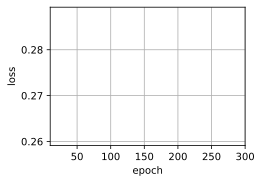

In [5]:
lr = 0.005
num_epochs = 300
device = myUtils.try_gpu()

# 训练
train_seq2seq(net,
              train_iter,
              lr,
              num_epochs,
              tgt_vocab,
              device)

In [7]:
# 保存模型
net = net.to("cpu")

import datetime
str_time = str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
save_path = 'transformer_net_%s.pt' % str_time
torch.save(net, save_path)  # 全保存 39M
print("训练完毕, 模型 %s 已保存至当前路径" % save_path)

训练完毕, 模型 transformer_net_2023-06-28_17-03-05.pt 已保存至当前路径


In [8]:
# 预测数据
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
num_steps = 10
net = net.to("cuda")
device = myUtils.try_gpu()

# 预测
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(net,
                                                        eng,
                                                        src_vocab,
                                                        tgt_vocab,
                                                        num_steps,
                                                        device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => <unk> ., bleu 0.000
i lost . => je suis <unk> ., bleu 0.000
he's calm . => il est <unk> ., bleu 0.658
i'm home . => je suis <unk> ., bleu 0.512
